In [1]:
# TODOs
# Deal with subject and body
# theory : why spam_prob / non_spam_prob < threshold ? 

In [2]:
import numpy as np
import pandas as pd
import os
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [3]:
def draw_plot(x, y, x_label, y_label, title):    
    x = np.array(x)
    y = np.array(y)
    plt.plot(x, y)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [44]:
path = "part"
SPAM = "spmsg"
LEGIT = "legit"

def getMessages():
    messages = pd.DataFrame(columns=['folder', 'subject', 'text', 'spam'])
    for folderNumber in range (1, 11):
        curPath = path + str(folderNumber)
        spam = []
        legit = []
        for filename in os.listdir(curPath):
            file = open(curPath + "/" + filename, 'r')
            subject = list(map(int, file.readline().split()[1:]))
            file.readline()
            text = list(map(int, file.readline().split()))
            legit_flag = LEGIT in filename
            cur_msg = pd.DataFrame([[folderNumber, subject, text, legit_flag]], columns=['folder', 'subject', 'text', 'spam'])
            messages = messages.append(cur_msg, ignore_index=True)
    return messages

In [45]:
pd.set_option('max_colwidth',25)
full_messages = getMessages()
print (full_messages)

     folder                   subject                      text   spam
0         1                   [14486]  [14486, 80, 196, 64, ...  False
1         1  [12091, 16398, 21903,...  [86, 86, 86, 86, 86, ...  False
2         1     [2056, 118, 4053, 47]  [19071, 80, 2176, 134...  False
3         1  [1692, 17345, 10936, ...  [16735, 16721, 2843, ...  False
4         1  [23340, 1967, 12372, ...  [19054, 7634, 1847, 2...   True
5         1        [2056, 118, 10911]  [4533, 4407, 1967, 14...   True
6         1                   [19071]  [284, 14851, 80, 1734...   True
7         1     [130, 4053, 6592, 84]  [284, 716, 80, 82, 82...  False
8         1  [12243, 15462, 47, 47...  [15964, 22301, 1363, ...  False
9         1                    [9450]  [6306, 118, 86, 86, 1...   True
10        1  [12314, 1967, 16502, ...  [17345, 4339, 8962, 2...  False
11        1  [23724, 118, 7745, 13...  [68, 16474, 1812, 173...   True
12        1  [167, 190, 82, 3115, ...  [82, 82, 82, 82, 82, ...   True
13    

In [46]:
print(full_messages['text'][0])

[14486, 80, 196, 64, 1896, 8962, 14328, 2130, 16502, 9211, 84, 196, 4339, 180, 16926, 18247, 18957, 14403, 4053, 23476, 2130, 16502, 752, 23266, 17348, 8857, 1991, 16502, 16926, 84, 1812, 17345, 21366, 15820, 18998, 84, 84, 84, 765, 4784, 84, 1812, 15691, 80, 18948, 196, 1591, 16085, 14338, 19054, 10248, 84, 118, 70]


In [138]:
class BayesianClassifier:
    unique_words_cnt = 0
    words = []
    class_freq = []
    words_cnt = []
    class_size = []
    
    def train(self, messages):
        self.class_freq = np.zeros(2) # P(C)
        self.words_cnt = [np.zeros(25000), np.zeros(25000)] # P(w_i | C) = P(w_i * C) / P(C) P(A | B)
        self.messages = messages
        
        self.class_size = self.messages['spam'].value_counts()
        self.class_freq[0] = self.class_size[False] / len(self.messages)
        self.class_freq[1] = self.class_size[True] / len(self.messages)
        
        for index, row in self.messages.iterrows():
            if row['spam']:
                id = 1
            else:
                id = 0
            
            self.add_to_freq(row['subject'], self.words_cnt[id])
            self.add_to_freq(row['text'], self.words_cnt[id])
        self.unique_words_cnt = len(np.unique(self.words))
            

    def add_to_freq(self, text, freq):
        for word in np.unique(text):
            freq[word] += 1
            self.words.append(word)
        
    def map_to_probs(self, clazz, lapl):
        q = 0
        if lapl:
            q = 1
        return lambda word_id : (self.words_cnt[clazz][word_id] + q) / (self.class_size[clazz] + q * self.unique_words_cnt)
        
    def classify(self, row, lapl = False, threshold=1., divider = 1.):
        text = np.int_(np.unique(row['text']))
        subj = np.int_(np.unique(row['subject']))
        
        c = len(text) / (len(subj) + 1)
        c /= divider
        
        non_spam_text = self.map_to_probs(False, lapl)(text)
        non_spam_subj = self.map_to_probs(False, lapl)(subj)
        non_spam = np.sum(np.log(np.maximum(non_spam_text, 1e-10))) + c * np.sum(np.log(np.maximum(non_spam_subj, 1e-10))) + np.log(self.class_freq[0])
        
        spam_text = self.map_to_probs(True, lapl)(text)
        spam_subj = self.map_to_probs(True, lapl)(subj)
        spam = np.sum(np.log(np.maximum(spam_text, 1e-10))) + c * np.sum(np.log(np.maximum(spam_subj, 1e-10))) + np.log(self.class_freq[1])
        
        return spam / non_spam < threshold

In [139]:
# slow cell
classifiers = []
train_messages = []
test_messages = []

for i in range(1, 11):
    train_messages.append(full_messages.loc[full_messages['folder'] != i])
    test_messages.append(full_messages.loc[full_messages['folder'] == i])
    temp_b = BayesianClassifier()
    temp_b.train(train_messages[i - 1])
    classifiers.append(temp_b)

In [144]:
def calc_accuracy(classifier, test_messages, threshold, c):
    correct = 0
    for index, row in test_messages.iterrows():
        if (classifier.classify(row, True, threshold, c) == row['spam']):
            correct += 1
    return correct / len(test_messages)

def cross_val(messages):
    
    for c in range(1, 51):
        average = 0
        for i in range(0, 10):
            temp = calc_accuracy(classifiers[i], test_messages[i], 1.0, c)
            average += temp
#             print(temp)
        
        print("c: {} average: {}".format(c, average / 10))

In [145]:
cross_val(full_messages)

c: 1 average: 0.9697247706422019
c: 2 average: 0.9761467889908257
c: 3 average: 0.9798165137614678
c: 4 average: 0.9807339449541284
c: 5 average: 0.9807339449541284
c: 6 average: 0.9798165137614678
c: 7 average: 0.9807339449541285
c: 8 average: 0.9807339449541285
c: 9 average: 0.9825688073394497
c: 10 average: 0.9834862385321103
c: 11 average: 0.9825688073394495
c: 12 average: 0.9825688073394495
c: 13 average: 0.9825688073394495
c: 14 average: 0.9825688073394495
c: 15 average: 0.9825688073394495
c: 16 average: 0.9825688073394495
c: 17 average: 0.9825688073394495
c: 18 average: 0.9834862385321103
c: 19 average: 0.9834862385321103
c: 20 average: 0.9834862385321103
c: 21 average: 0.9834862385321103
c: 22 average: 0.9834862385321103
c: 23 average: 0.9834862385321103
c: 24 average: 0.9834862385321103
c: 25 average: 0.9834862385321103
c: 26 average: 0.9834862385321103
c: 27 average: 0.9834862385321103
c: 28 average: 0.9834862385321103
c: 29 average: 0.9834862385321103
c: 30 average: 0.983486

In [39]:
def calc_tp_fp(classifiers, test_messages_arr, threshold):
    tp = 0
    fp = 0
    for index, row in test_messages_arr[0].iterrows():
        if (classifiers[0].classify(row, True, threshold) == row['spam'] and row['spam']):
            tp += 1
        if (classifiers[0].classify(row, True, threshold) != row['spam'] and not row['spam']):
            fp += 1
    return tp, fp

In [40]:
def calc_and_draw_ROC():
    true_positive = []
    false_positive = []
    
    full_positive = 0
    full_negative = 0
    for index, row in test_messages[0].iterrows():
        if (row['spam']):
            full_positive += 1
        else:
            full_negative += 1
            
    for step in np.linspace(0.3, 2, num=200):
        tp, fp = calc_tp_fp(classifiers, test_messages, step)
        true_positive.append(tp / full_positive)
        false_positive.append(fp / full_negative)
        plt.plot(fp / full_negative, tp / full_positive, "gs", markersize=1)
    plt.show()
        
#     draw_plot(false_positive, true_positive, " False Positive ", " True Positive ", "ROC-Curve")

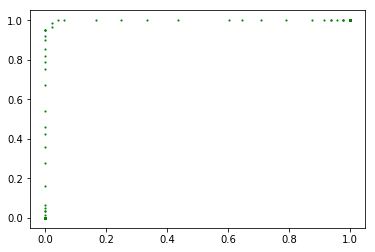

In [41]:
calc_and_draw_ROC()